#  Analysis of cell cycle dataset from scEU-seq

## Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import dynamo as dyn

In [2]:
from dynamo_pp_workflow import dynamo_pp_workflow

In [3]:
import storm

## Load data

In [4]:
rpe1 = dyn.read_h5ad('./data/rpe1.h5ad')

In [5]:
dyn.convert2float(rpe1, ['Cell_cycle_possition', 'Cell_cycle_relativePos'])

In [6]:
rpe1_kinetics = rpe1[rpe1.obs.exp_type=='Pulse', :]
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(str)
rpe1_kinetics.obs.loc[rpe1_kinetics.obs['time'] == 'dmso', 'time'] = -1
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(float)
rpe1_kinetics = rpe1_kinetics[rpe1_kinetics.obs.time != -1, :]

In [7]:
rpe1_kinetics.layers['new'], rpe1_kinetics.layers['total'] = rpe1_kinetics.layers['ul'] + rpe1_kinetics.layers['sl'], rpe1_kinetics.layers['su'] + rpe1_kinetics.layers['sl'] + rpe1_kinetics.layers['uu'] + rpe1_kinetics.layers['ul']

del rpe1_kinetics.layers['uu'], rpe1_kinetics.layers['ul'], rpe1_kinetics.layers['su'], rpe1_kinetics.layers['sl']

In [8]:
rpe1_kinetics.obs.time = rpe1_kinetics.obs.time.astype('float')
rpe1_kinetics.obs.time = rpe1_kinetics.obs.time/60 # convert minutes to hours

## Preprocess data using Dynamo package

In [9]:
dynamo_pp_workflow(adata=rpe1_kinetics, tkey='time', experiment_type='kin', n_top_genes=1000)

|-----> Running monocle preprocessing pipeline...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.


1 input query terms found dup hits:	[('ENSG00000249738', 2)]
52 input query terms found no hit:	['ENSG00000112096', 'ENSG00000116957', 'ENSG00000130723', 'ENSG00000168078', 'ENSG00000189144', 'ENS


|-----> Subsetting adata object and removing Nan columns from adata when converting gene names.
|-----------> filtered out 0 outlier cells
|-----------> filtered out 944 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [18.6542s]
|-----> [Cell Cycle Scores Estimation] completed [0.3123s]
|-----> [Preprocessor-monocle] completed [11.5610s]
|-----> calculating first/second moments...
|-----> [moments calculation] completed [17.2605s]


## Run Storm's parameter inference and RNA velocity estimation methods

In [10]:
storm.storm_kin_data(adata=rpe1_kinetics, use_genes=rpe1_kinetics.var_names[rpe1_kinetics.var.use_for_pca],
                     assumption='non_steady_state', method='CSP_Baseline')

Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:02, 398.61it/s]
Infer parameters via maximum likelihood estimation based on the CSP model: 1000it [00:13, 72.08it/s]


## Visualize RNA velocity results using Dynamo package

In [11]:
rpe1_kinetics.uns["dynamics"] = {"has_splicing" : False, "has_labeling" : True}

In [12]:
def streamline(adata):
    dyn.tl.reduceDimension(adata, reduction_method='umap')
    dyn.tl.cell_velocities(adata, enforce=True, vkey='velocity_T', ekey='M_t', basis='RFP_GFP',
                          transition_genes=adata.var_names[adata.var.select_genes])
    dyn.pl.streamline_plot(adata, color=['cell_cycle_phase'], basis='RFP_GFP')
    return adata

|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [8.2739s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [2.9692s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] 

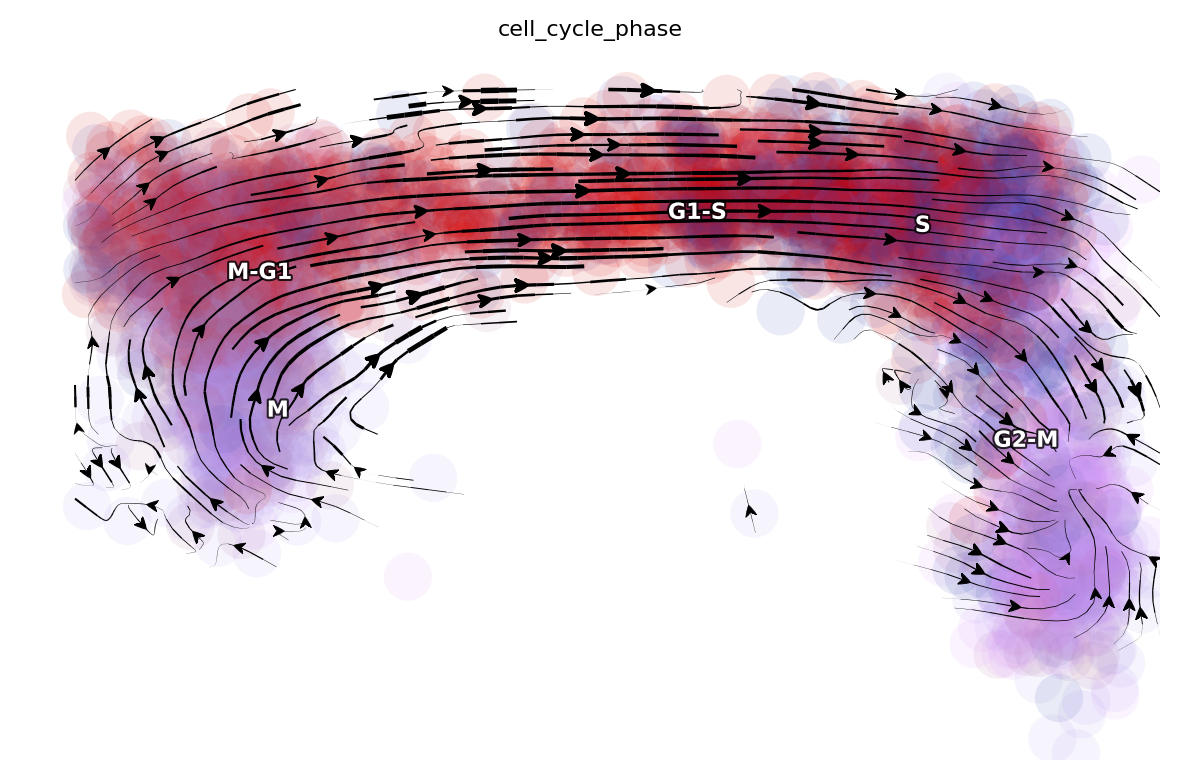

AnnData object with n_obs × n_vars = 2793 × 11511
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 'exp_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'Gene_Id', 'query', 'scopes', '_id', '_score', 'symbol', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'frac', 'use_for_pca', 'ntr', 'gamma', 'gamma_r2', 'alpha', 'select_genes', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'feature_selection', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'cell_phase_order', 'cell_phase_genes', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_RFP_GFP', 'cell_cycle_phase_colors'
    obsm: 'X_pca', 'cell_cycle_scores', 'X_RFP_GFP', 'X_umap', 'velocity_RFP_GFP'
    layers: 'new', 'total', 'X_new', '

In [13]:
rpe1_kinetics.obsm['X_RFP_GFP'] = rpe1_kinetics.obs.loc[:, ['RFP_log10_corrected', 'GFP_log10_corrected']].values.astype('float')
streamline(rpe1_kinetics)